c:\users\harwister\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(6400, 300)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.07s/it]


[[ -6269918.32772931 -43760198.75584403 -42520118.0249727  ...
  -44029763.67325075 -42567779.51118564 -36992294.35912425]
 [-10137339.43540513 -58121498.91396941 -56598627.0437419  ...
  -58833588.17897331 -56991544.14228307 -49897441.52778666]
 [-13027255.33886126  -3190494.32659122  -3149368.3188991  ...
   -3225568.3715977   -3190943.19917124  -3070095.85189595]
 ...
 [-12388603.30819286 -46948456.85238332 -45578091.75431067 ...
  -47274731.21186951 -45670870.07634457 -39591474.15801151]
 [-10802055.4541088  -17281064.98058973 -16784822.14992997 ...
  -17288128.93649024 -16729128.88274972 -14631332.23812098]
 [ -2554057.91576935 -18060488.33340598 -17550505.73364903 ...
  -18173278.5585665  -17571632.6522265  -15276298.94086582]]
[[ -262.94728256  -157.5318979    237.77931601 ...  -253.16265805
   -263.71870591   -60.804644  ]
 [ -433.72285715  -406.20708908    59.88899012 ...    49.8451563
     45.12819489  -169.12897944]
 [ -973.75671389    11.5448298  -1022.82939891 ...  -309.74

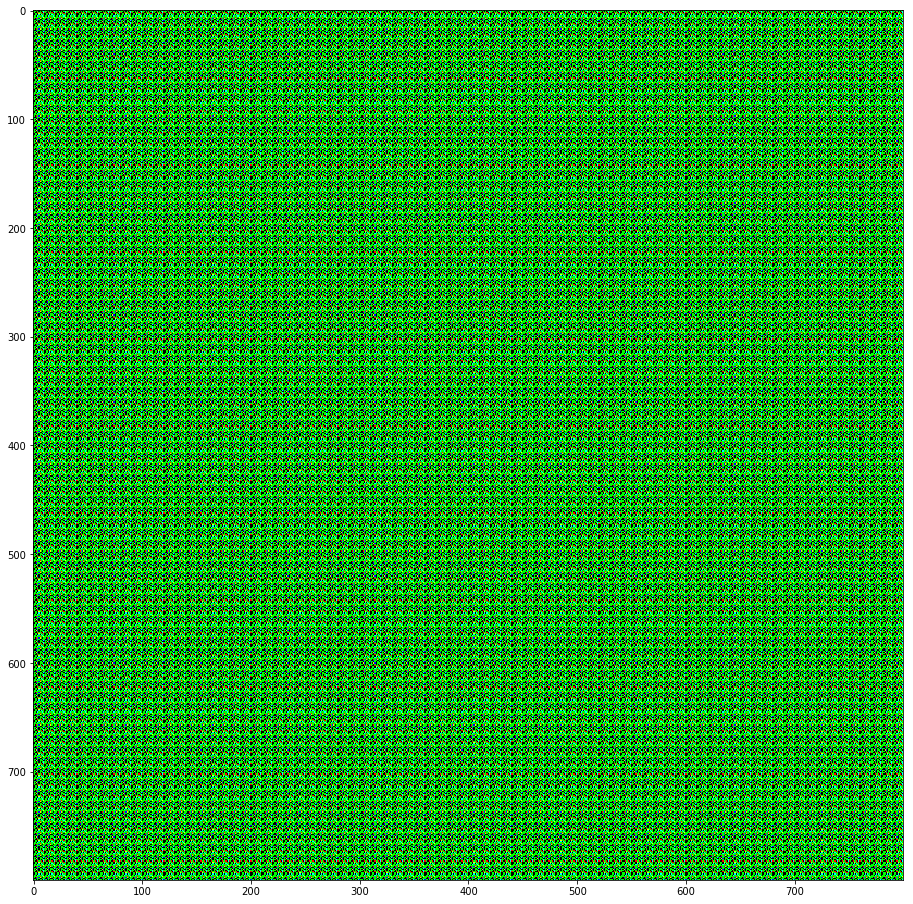

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy import misc
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import copy
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import scipy.optimize
import networkx as nx
import os
from sklearn import svm
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist




def show_image(img):
    fig = plt.figure(figsize=(18, 16))
    plt.imshow(img)
    plt.show()

def normalize_image(img):
    # return (2*img / 255)-1
    return img / 255


def denormalize_image(img):
    # return ((img + 1)*255/2).astype('int32')
    return (img * 255).astype('int32')

def read_png(path='linux.png'):
    img = misc.imread(path).astype('int32')
    # show_image(img)
    # uncomment the below code to view the loaded image
    return img

img = read_png()
img =  normalize_image(img)


def rect_split(img, h=10, w=10):
    rects = []
    for height in range(int(img.shape[0]/h)):
        for width in range(int(img.shape[1]/w)):
            rects.append(img[width*w:width*w+w, height*h:height*h+h].flatten())
    rects = np.array(rects)
    return rects


def rect_join(rects, h=10, w=10, rh=800, rw=800):
    i = 0
    img = None
    for height in range(int(rh / h)):
        row = None
        for width in range(int(rw / w)):
            restore = rects[i].reshape(h,w,3)
            i += 1
            row = restore if row is None else np.vstack((row, restore))
        img = row if img is None else np.hstack((img,row))
    return img




rects = rect_split(img)
print(rects.shape)

# sigmoid
def activation(x):
    return 1 / (1 + np.exp(-x))


# функция прямого распространения
def predict(x, theta_1, theta_2, return_hidden_layer = False):
    # theta_1 and theta_2 is neural network config for lay1 and lay2
    ex_x = np.hstack((np.ones((len(x), 1)), x)) #расширение матрицы для умножения с первым слоем
    lay_1_out = activation(ex_x.dot(theta_1.T)) #векторное умножение с последующим применением функции  активации
    ex_lay_1_out = np.hstack((np.ones((len(lay_1_out), 1)), lay_1_out)) #расширение результирующей матрицы для умножения со вторым слоем
    lay_2_out = activation(ex_lay_1_out.dot(theta_2.T)) #векторное умножение с последующим применением функции активации даёт на выходе матрицу ответов от нейронной сети(матрица предсказаний)
    return ex_lay_1_out if return_hidden_layer else lay_2_out

def create_random_theha(shape):
    import random
    theta = []
    for _ in range(shape[0]):
        theta.append(np.array([random.uniform(-1, 1) for _ in range(shape[1])]))
    return np.array(theta)


rand_tetha_1 = create_random_theha((280, 301))
rand_tetha_2 = create_random_theha((300, 281))

predictions = predict(rects, rand_tetha_1, rand_tetha_2)

# initial output
img = rect_join(predictions)
img = denormalize_image(img)
# show_image(img)

def sigmoid_speed(x):
    return np.exp(-x) / ((1 + np.exp(-x)) ** 2)


def revert_error_spread_train(x, rand_tetha_1, rand_tetha_2, y):
    for _ in tqdm(range(20)):
        predicted = predict(x, rand_tetha_1, rand_tetha_2)
        lay_1_predicted = predict(x, rand_tetha_1, rand_tetha_2, return_hidden_layer=True)
        l2error = y - predicted
        l2delta = l2error * sigmoid_speed(predicted)
        l1error = np.dot(l2delta, rand_tetha_2)
        l1delta = l1error * sigmoid_speed(lay_1_predicted)
        l1delta = np.delete(l1delta, 0, 1)
        ex_x = np.hstack((np.ones((len(x), 1)), x))  # расширение матрицы для умножения с первым слоем
        rand_tetha_1 += np.dot(ex_x.T, l1delta).T
        rand_tetha_2 += np.dot(lay_1_predicted.T, l2delta).T
    return rand_tetha_1, rand_tetha_2


# la 1
# al 1000
# i 10
def gradient(x,  base_theta_1, base_theta_2, y, lambda_=10000, alpha=1000000, iterations = 100):
    for _ in tqdm(range(int(iterations))):
        ex_x = np.hstack((np.ones((len(x), 1)), x))  # расширение матрицы для умножения с первым слоем
        layer1 = activation(np.dot(ex_x, base_theta_1.T))
        ex_lay_1_out = np.hstack((np.ones((len(layer1), 1)), layer1))  # расширение результирующей матрицы для умножения со вторым слоем
        layer2 = activation(np.dot(ex_lay_1_out, base_theta_2.T))
        layer2delta = (layer2 - y) * (layer2 * (1-layer2))
        layer1delta = np.dot(layer2delta, base_theta_2) * (ex_lay_1_out * (1-ex_lay_1_out))
        l2_regularization = 1 - lambda_ / len(x)
        base_theta_2 = base_theta_2 * l2_regularization - alpha * np.dot(ex_lay_1_out.T, layer2delta).T
        layer1delta = np.delete(layer1delta, 0, 1)
        base_theta_1 = base_theta_1 * l2_regularization - alpha * np.dot(ex_x.T, layer1delta).T
    return np.array([base_theta_1, base_theta_2])




def inp(string, defalut):
    user = input(string)
    if user == "":
        return defalut
    else:
        return float(user)


def expect():
    la = 10
    al = 0
    i = 20

    while True:
        # try:
            la = inp("lambda", la)
            al = inp("alpha", al)
            i = inp("iter", i)
            trained_tetha_1, trained_tetha_2 = gradient(rects, rand_tetha_1, rand_tetha_2, rects, lambda_=la, alpha=al, iterations = i)
            predictions = predict(rects, trained_tetha_1, trained_tetha_2)
            # initial output
            img = rect_join(predictions)
            img = denormalize_image(img)
            show_image(img)

# expect()

trained_tetha_1, trained_tetha_2 = revert_error_spread_train(rects, rand_tetha_1, rand_tetha_2, rects)
print(trained_tetha_1)
print(trained_tetha_2)
predictions = predict(rects, trained_tetha_1, trained_tetha_2)
# initial output
img = rect_join(predictions)
img = denormalize_image(img)
show_image(img)
    # except:
    #     print()
# img = rect_join(rects)
# img = denormalize_image(img)
# show_image(img)


# 0
# 1000
# 10














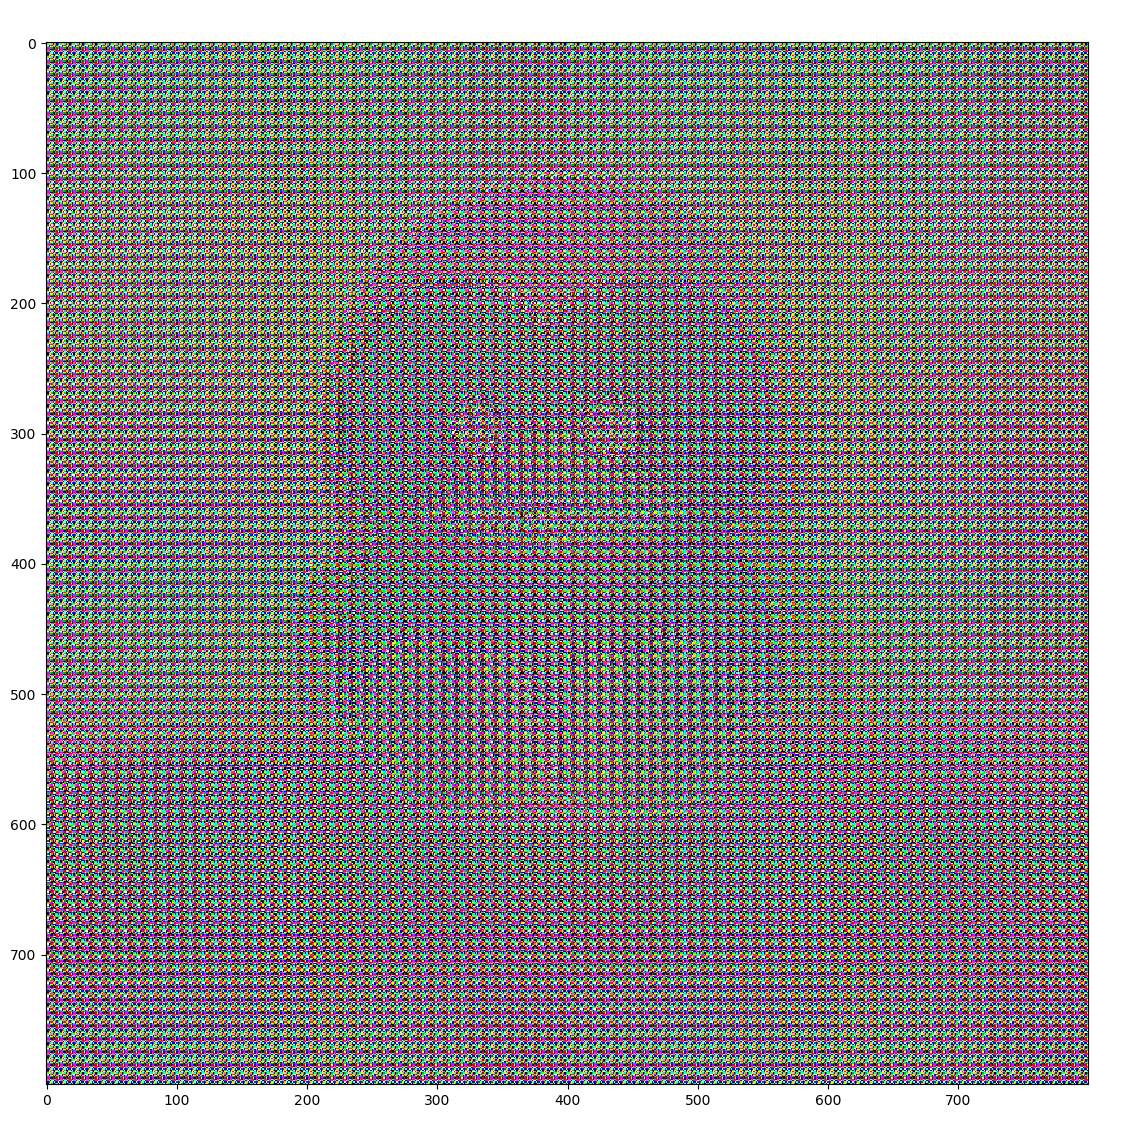